In [10]:
import numpy as np
import matplotlib.pyplot as plt

import model_fins as modfins

import copy
from tqdm import tqdm
from itertools import product

In [11]:
def heat_transfer_tube(T):
    # Total heat transfer at the tube interface: total_heat_transfer W per unit depth

    # Compute the total heat transfer at the tube interface
    total_heat_transfer = 0.0

    # Tube center coordinates
    x_center = w_fin / 2
    y_center = H_fin / 2

    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            if not tube_mask[i, j]:
                # Check if adjacent to the tube
                neighbors = [
                    tube_mask[i+1, j],
                    tube_mask[i-1, j],
                    tube_mask[i, j+1],
                    tube_mask[i, j-1]
                ]
                if any(neighbors):
                    # Position of the node
                    x_i = x[i]
                    y_j = y[j]
                    # Vector from node to tube center
                    dx_c = x_i - x_center
                    dy_c = y_j - y_center
                    distance = np.hypot(dx_c, dy_c)
                    # Normal vector pointing towards the tube center
                    n_x = -dx_c / distance
                    n_y = -dy_c / distance
                    # Temperature gradient
                    dT_dx = (T[i+1, j] - T[i-1, j]) / (2 * dx)
                    dT_dy = (T[i, j+1] - T[i, j-1]) / (2 * dy)
                    # Normal temperature gradient
                    dT_dn = dT_dx * n_x + dT_dy * n_y
                    # Heat flux
                    q_n = -k * dT_dn
                    # Increment total heat transfer
                    # Multiply by the segment length (approximate as grid spacing)
                    segment_length = (dx + dy) / 2  # Average grid spacing
                    total_heat_transfer += q_n * segment_length

    return total_heat_transfer

In [12]:
def integral_heat_transfer_fin(T, dx, dy, tube_mask, h, T_amb):
    # Calculate the area of each cell (since we're in 2D, per unit depth)
    A_cell = dx * dy  # Area of each cell

    # Create a mask for fin cells (excluding the tube)
    fin_mask = ~tube_mask

    # Compute the temperature difference (T_cell - T_amb) for fin cells
    delta_T = T - T_amb
    delta_T[~fin_mask] = 0  # Set delta_T to zero where it's not part of the fin

    # Compute the heat transfer from each cell
    q_cell = h * A_cell * delta_T

    # Total heat transfer over the fin
    total_heat_transfer_fin = np.sum(q_cell)

    return total_heat_transfer_fin

def solve_2D_conduction_fin(geom, conditions):

    # Physical Parameters
    h = conditions['h']          # Heat transfer coefficient (W/m²·K)
    T_tube = conditions['T_tube']    # Temperature of the tube (°C)
    T_amb = conditions['T_amb']     # Ambient temperature (°C)

    # Geometry Parameters
    w_fin = geom['w_fin']     # Width of the fin (m)
    H_fin = geom['H_fin']     # Height of the fin (m)
    k = geom['k']         # Thermal conductivity of the fin material (W/m·K)

    # Numerical Parameters
    Nx = geom['Nx']        # Number of grid points in x-direction
    dx = w_fin / (Nx - 1)
    Ny = int((H_fin/w_fin) * Nx)        # Number of grid points in y-direction
    dy = H_fin / (Ny - 1)

    # Create the grid
    x = np.linspace(0, w_fin, Nx)
    y = np.linspace(0, H_fin, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    tube_shape = geom['tube_shape']

    if tube_shape == 'circle':

        R_tube = geom['R_tube']   # Radius of the tube (m)
        # Create a mask for the tube
        tube_mask = (X - w_fin / 2)**2 + (Y - H_fin / 2)**2 <= R_tube**2

    elif tube_shape == 'rectangle':

        # Define the side length of the square (tube)
        L_tube = geom['L_tube']  # Side length of the square (m)

        # Center coordinates of the square
        x_center = w_fin / 2
        y_center = H_fin / 2

        # Create a mask for the square
        tube_mask = (
            (np.abs(X - x_center) <= L_tube / 2) &
            (np.abs(Y - y_center) <= L_tube / 2)
        )

    else:
        raise ValueError('Invalid tube shape. Use "circle" or "rectangle".')
    
    # Initialize temperature field
    T = np.ones((Nx, Ny)) * T_amb

    # Apply Dirichlet condition at the tube surface
    T[tube_mask] = T_tube

    # Iterative Solver Parameters
    report_tolerance = 0.0001
    tolerance = 1e-4
    max_iterations = 50000
    omega = 1.5  # Over-relaxation factor for SOR method

    # Precompute constants
    A = 1 / dx**2
    B = 1 / dy**2
    C = h / k
    D = 2 * (A + B) + C

    error_list = []
    report_list = []

    # Start the iterative solver
    for iteration in tqdm(range(max_iterations), total=max_iterations):
        T_old = T.copy()
        
        # Update internal nodes
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                if not tube_mask[i, j]:
                    # Updated finite difference equation with convection term
                    numerator = (
                        A * (T[i+1, j] + T[i-1, j]) +
                        B * (T[i, j+1] + T[i, j-1]) +
                        C * T_amb
                    )
                    T[i, j] = numerator / D
        
        # Apply Neumann boundary conditions (sides and bottom)
        T[0, :] = T[1, :]       # Left edge
        T[-1, :] = T[-2, :]     # Right edge
        T[:, 0] = T[:, 1]       # Bottom edge
        T[:, -1] = T[:, -2]     # Top edge
        
        # Apply Robin boundary condition (top edge)
        # T[:, -1] = (k * T[:, -2] / dy + h * T_amb) / (k / dy + h)
        
        # Check for convergence
        error = np.max(np.abs(T - T_old))
        error_list.append(error)
        report_list.append(integral_heat_transfer_fin(T, dx, dy, tube_mask, h, T_amb))

        if iteration >= 1000:
            report_error = np.array([abs((report_list[-i] - report_list[-i-1])/report_list[-i-1]) for i in range(1, 50)]).mean()

            if (error < tolerance) and (report_error < report_tolerance):
                print(f'Converged after {iteration} iterations.')
                break
            
    if iteration == max_iterations - 1:
        print('Did not converge within the maximum number of iterations.')

    T_res = copy.deepcopy(T)

    return T_res, error_list, report_list

In [13]:
geom = {
    'w_fin' : 0.1,
    'H_fin' : 0.2,
    'Nx' : 120,
    'k' : 226,
    'tube_shape' : 'rectangle',
    'L_tube' : 0.01
}

conditions = {'T_amb' : 0.+273.15,
               'T_tube' : -8+273.15,
               'h' : 5}

In [14]:
w_fin_range = np.linspace(0.03, 0.2, 6)
H_fin_range = np.linspace(0.01, 0.3, 4)

DT_tube_range = np.array([-10, -6, -2])
h_range = np.linspace(0.5, 10, 4)

In [ ]:
res_list = []

for w_fin, H_fin, DT_tube, h in tqdm(product(w_fin_range, H_fin_range, DT_tube_range, h_range), 
                                     total=len(w_fin_range) * len(H_fin_range) * len(DT_tube_range) * len(h_range), 
                                     desc="Total Progress"):
    
    geom_local = copy.deepcopy(geom)
    conditions_local = copy.deepcopy(conditions)
    
    geom_local['w_fin'] = w_fin
    geom_local['H_fin'] = H_fin
    geom_local['Nx'] = int(150 * w_fin / 0.1)
    conditions_local['T_tube'] = conditions_local['T_amb'] + DT_tube
    conditions_local['h'] = h
    T_res, error_list, report_list = solve_2D_conduction_fin(geom_local, conditions_local)
    
    res_list.append({**geom_local, **conditions_local, 'T' : T_res, 'error_list' : error_list, 'report_list' : report_list})

In [ ]:
error_list[-1]

In [ ]:
plt.plot(error_list)
plt.ylim(0,0.0002)

In [ ]:
plt.plot(report)
# plt.ylim(-0.075, -0.065)

In [ ]:
0.002/0.070

In [ ]:
report

In [ ]:
# Plot the temperature distribution with the tube boundary
plt.figure(figsize=(8, 6))
plt.imshow(T.T, extent=[0, w_fin, 0, H_fin], origin='lower', cmap='hot', aspect='equal')
plt.colorbar(label='Temperature (°C)')
plt.title('Temperature Distribution in the Fin')
plt.xlabel('Width (m)')
plt.ylabel('Height (m)')

if tube_shape == 'circle':

    # Overlay the tube boundary
    theta = np.linspace(0, 2 * np.pi, 100)
    x_center = w_fin / 2
    y_center = H_fin / 2
    x_circle = x_center + R_tube * np.cos(theta)
    y_circle = y_center + R_tube * np.sin(theta)
    plt.plot(x_circle, y_circle, 'k', linewidth=2, color='white')

elif tube_shape == 'rectangle':

    # Coordinates of the square corners
    half_L = L_tube / 2
    x_square = [
        x_center - half_L, x_center + half_L, x_center + half_L, x_center - half_L, x_center - half_L
    ]
    y_square = [
        y_center - half_L, y_center - half_L, y_center + half_L, y_center + half_L, y_center - half_L
    ]

    # Overlay the square boundary
    plt.plot(x_square, y_square, 'k', linewidth=2, color='white')

plt.show()

In [15]:
import heat_transfer as bht

In [ ]:
calculated = report[-1]
calculated

In [ ]:
2*H_fin

In [ ]:
(2*h*H_fin**2)/(9*k)

In [ ]:
lambda_fin = 0.001
Bi = bht.Biot(lambda_fin, k, h, H_fin)
Ac = lambda_fin * H_fin

theoretical = modfins.gamma_fin('free_end', (w_fin-L_tube)/2, lambda_fin, Ac, k, Bi) * (T_tube - T_amb)
print('Bi', Bi)
print('theory', theoretical)
np.abs(calculated - theoretical) / theoretical

In [ ]:
Bi

In [ ]:
calculated

In [ ]:
theoretical

In [ ]:
5*(-7.8 - (0)) * w_fin * H_fin

In [ ]:
report[-1]

In [ ]:


print(f'Total heat transfer over the fin due to convection: {total_heat_transfer_fin:.2f} W per unit depth')

In [ ]:
3782*0.001

In [ ]:
# Compute temperature gradients
dT_dx = np.zeros_like(T)
dT_dy = np.zeros_like(T)

# Compute gradients for internal nodes
for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
        if not tube_mask[i, j]:
            # Handle boundaries near the tube
            if not tube_mask[i+1, j] and not tube_mask[i-1, j]:
                dT_dx[i, j] = (T[i+1, j] - T[i-1, j]) / (2 * dx)
            elif not tube_mask[i+1, j]:
                dT_dx[i, j] = (T[i+1, j] - T[i, j]) / dx
            elif not tube_mask[i-1, j]:
                dT_dx[i, j] = (T[i, j] - T[i-1, j]) / dx
            else:
                dT_dx[i, j] = 0  # Cannot compute gradient accurately
                
            if not tube_mask[i, j+1] and not tube_mask[i, j-1]:
                dT_dy[i, j] = (T[i, j+1] - T[i, j-1]) / (2 * dy)
            elif not tube_mask[i, j+1]:
                dT_dy[i, j] = (T[i, j+1] - T[i, j]) / dy
            elif not tube_mask[i, j-1]:
                dT_dy[i, j] = (T[i, j] - T[i, j-1]) / dy
            else:
                dT_dy[i, j] = 0  # Cannot compute gradient accurately
        else:
            # Inside the tube, gradients are zero
            dT_dx[i, j] = 0
            dT_dy[i, j] = 0

# Set gradients to zero where tube exists
dT_dx[tube_mask] = 0
dT_dy[tube_mask] = 0

# Compute heat flux components
q_x = -k * dT_dx
q_y = -k * dT_dy

# Compute the magnitude of the heat flux
q_mag = np.sqrt(q_x**2 + q_y**2)

# Set heat flux magnitude to zero inside the tube
q_mag[tube_mask] = 0

# Plot the heat flux magnitude map
plt.figure(figsize=(8, 6))
plt.imshow(q_mag.T, extent=[0, w_fin, 0, H_fin], origin='lower', cmap='hot', aspect='equal')
plt.colorbar(label='Heat Flux Magnitude (W/m²)')
plt.title('Heat Flux Magnitude in the Fin')
plt.xlabel('Width (m)')
plt.ylabel('Height (m)')

# Overlay the tube boundary
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = w_fin / 2 + R_tube * np.cos(theta)
y_circle = H_fin / 2 + R_tube * np.sin(theta)
plt.plot(x_circle, y_circle, 'k', linewidth=2)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Lx = 0.1  # Length of the fin in x-direction (m)
Ly = 0.1  # Length of the fin in y-direction (m)
a = 0.005  # Thickness of the fin (m)
dx = dy = 0.005  # Spatial discretization step (m)
nx = int(Lx / dx) + 1  # Number of nodes in x-direction
ny = int(Ly / dy) + 1  # Number of nodes in y-direction
k = 205  # Thermal conductivity of fin material (W/m·K) (e.g., aluminum)
h = 10  # Heat transfer coefficient (W/m²·K)
T_amb = 273.15  # Ambient temperature (°C)
T_tube = 263.15  # Tube temperature (°C)

# Generate grid
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Initialize temperature array
T = np.ones((nx, ny)) * T_amb

# Identify the tube boundary (circle at the center)
tube_radius = 0.02  # Tube radius (m)
tube_center = (Lx / 2, Ly / 2)
tube_mask = (X - tube_center[0])**2 + (Y - tube_center[1])**2 <= tube_radius**2

# Set tube boundary temperature
T[tube_mask] = T_tube

# Finite difference coefficients
# For simplicity, we assume uniform grid spacing: dx = dy
dx2 = dx * dx
dy2 = dy * dy
A = np.zeros((nx * ny, nx * ny))
b = np.zeros(nx * ny)

# Map 2D indices to 1D index
def idx(i, j):
    return i * ny + j

# Assemble the system
for i in range(nx):
    for j in range(ny):
        p = idx(i, j)
        if tube_mask[i, j]:
            # Tube boundary node
            A[p, p] = 1
            b[p] = T_tube
        else:
            # Coefficients for neighboring nodes
            aW = k / dx2
            aE = k / dx2
            aS = k / dy2
            aN = k / dy2
            aP = -(aW + aE + aS + aN + 2 * h / a)
            
            # Initialize row in A and b
            A[p, p] = aP
            b[p] = -2 * h * T_amb / a  # Contribution from convection on top and bottom surfaces
            
            # West neighbor (i-1, j)
            if i == 0:
                # Insulated boundary at the left edge
                A[p, p] -= aW
            else:
                A[p, idx(i - 1, j)] = aW
            
            # East neighbor (i+1, j)
            if i == nx - 1:
                # Insulated boundary at the right edge
                A[p, p] -= aE
            else:
                A[p, idx(i + 1, j)] = aE
            
            # South neighbor (i, j-1)
            if j == 0:
                # Insulated boundary at the bottom edge
                A[p, p] -= aS
            else:
                A[p, idx(i, j - 1)] = aS
            
            # North neighbor (i, j+1)
            if j == ny - 1:
                # Convection boundary at the top edge
                # Modify aN and b[p] to include convection
                A[p, p] -= aN - h / dy
                b[p] -= h * T_amb / dy
            else:
                A[p, idx(i, j + 1)] = aN

# Solve the linear system
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

A_sparse = csr_matrix(A)
T_flat = spsolve(A_sparse, b)
T = T_flat.reshape((nx, ny))

# Plot the temperature distribution
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, T.T, 20, cmap='inferno')
plt.colorbar(cp)
plt.title('Temperature Distribution in the Fin')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('equal')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Lx = 0.1  # Length of the fin in x-direction (m)
Ly = 0.1  # Length of the fin in y-direction (m)
a = 0.005  # Thickness of the fin (m)
dx = dy = 0.001  # Spatial discretization step (m)
nx = int(Lx / dx) + 1  # Number of nodes in x-direction
ny = int(Ly / dy) + 1  # Number of nodes in y-direction
k = 205  # Thermal conductivity of fin material (W/m·K)
h = 10  # Heat transfer coefficient (W/m²·K)
T_amb = 80  # Ambient temperature (°C)
T_tube = 100  # Tube temperature (°C)

# Generate grid
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Identify the tube boundary (circle at the center)
tube_radius = 0.02  # Tube radius (m)
tube_center = (Lx / 2, Ly / 2)
tube_mask = (X - tube_center[0])**2 + (Y - tube_center[1])**2 <= tube_radius**2

# Finite difference coefficients
dx2 = dx * dx
dy2 = dy * dy
N = nx * ny
A = np.zeros((N, N))
b = np.zeros(N)

# Map 2D indices to 1D index
def idx(i, j):
    return i * ny + j

# Assemble the system
for i in range(nx):
    for j in range(ny):
        p = idx(i, j)
        if tube_mask[i, j]:
            # Tube boundary node
            A[p, p] = 1
            b[p] = T_tube
        else:
            # Initialize coefficients
            aP = 0
            aW = 0
            aE = 0
            aS = 0
            aN = 0

            # Convection on top and bottom surfaces (z-direction)
            aP -= 2 * h / a
            b[p] -= 2 * h * T_amb / a

            # Left boundary (i == 0)
            if i == 0:
                aP -= -2 * k / dx2
                aE = 2 * k / dx2
                A[p, idx(i + 1, j)] = aE
            else:
                aW = k / dx2
                A[p, idx(i - 1, j)] = aW

            # Right boundary (i == nx - 1)
            if i == nx - 1:
                aP -= -2 * k / dx2
                aW = 2 * k / dx2
                A[p, idx(i - 1, j)] = aW
            else:
                aE = k / dx2
                A[p, idx(i + 1, j)] = aE

            # Bottom boundary (j == 0)
            if j == 0:
                aP -= -2 * k / dy2
                aN = 2 * k / dy2
                A[p, idx(i, j + 1)] = aN
            else:
                aS = k / dy2
                A[p, idx(i, j - 1)] = aS

            # Top boundary (j == ny - 1)
            if j == ny - 1:
                # Convection boundary
                aP -= -k / dy2 - h / dy
                b[p] -= h * T_amb / dy
                aS = k / dy2
                A[p, idx(i, j - 1)] = aS
            else:
                aN = k / dy2
                A[p, idx(i, j + 1)] = aN

            A[p, p] = -(aW + aE + aS + aN) + aP

# Solve the linear system
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

A_sparse = csr_matrix(A)
T_flat = spsolve(A_sparse, b)
T = T_flat.reshape((nx, ny))

# Set tube temperature
T[tube_mask] = T_tube

# Plot the temperature distribution
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, T.T, 20, cmap='inferno')
plt.colorbar(cp)
plt.title('Temperature Distribution in the Fin')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('equal')
plt.show()


In [ ]:
T

In [5]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Parameters
L_x = 0.6          # Width of the fin (m)
L_y = 0.2          # Height of the fin (m)
dx = 0.001         # Grid spacing (m)
a = 0.001           # Fin thickness (m)
h = 10             # Convection coefficient (W/(m^2 K))
lambda_ = 226      # Thermal conductivity (W/(m K))
T_tube = 20       # Tube temperature (°C)
T_amb = 100         # Ambient temperature (°C)
R_tube = 0.02      # Tube radius (m)

# Derived parameters
nx = int(L_x / dx) + 1
ny = int(L_y / dx) + 1
beta = (2 * h * dx**2) / (lambda_ * a)

# Grid coordinates
x = np.linspace(0, L_x, nx)
y = np.linspace(0, L_y, ny)
X, Y = np.meshgrid(x, y)

# Total number of nodes
N = nx * ny

# Function to map 2D indices to 1D index
def idx(i, j):
    return i + j * nx

# Initialize the coefficient matrix and RHS vector
A = lil_matrix((N, N))
b = np.zeros(N)

# Build the coefficient matrix and RHS vector
for j in range(ny):
    for i in range(nx):
        n = idx(i, j)
        x_i = x[i]
        y_j = y[j]
        
        # Distance from the tube center
        distance = np.sqrt((x_i - L_x / 2)**2 + y_j**2)
        
        if distance <= R_tube:
            # Tube surface: T = T_tube
            A[n, n] = 1.0
            b[n] = T_tube
        else:
            # Initialize coefficients
            a_center = 4 + beta
            rhs = beta * T_amb
            a_left = -1
            a_right = -1
            a_down = -1
            a_up = -1
            
            # Left boundary (insulated)
            if i == 0:
                a_left = 0
                a_center += -1
            else:
                A[n, idx(i - 1, j)] = a_left
                
            # Right boundary (insulated)
            if i == nx - 1:
                a_right = 0
                a_center += -1
            else:
                A[n, idx(i + 1, j)] = a_right
                
            # Bottom boundary (insulated)
            if j == 0:
                a_down = 0
                a_center += -1
            else:
                A[n, idx(i, j - 1)] = a_down
                
            # Top boundary (convection)
            if j == ny - 1:
                hdx_lambda = h * dx / lambda_
                a_up = 0
                a_center += (1 - hdx_lambda)
                rhs += hdx_lambda * T_amb
            else:
                A[n, idx(i, j + 1)] = a_up
                
            # Set coefficients in A
            A[n, n] = a_center
            b[n] = rhs

# Solve the linear system
A = A.tocsr()
T = spsolve(A, b)

# Reshape the solution to a 2D grid
T_grid = T.reshape((ny, nx))


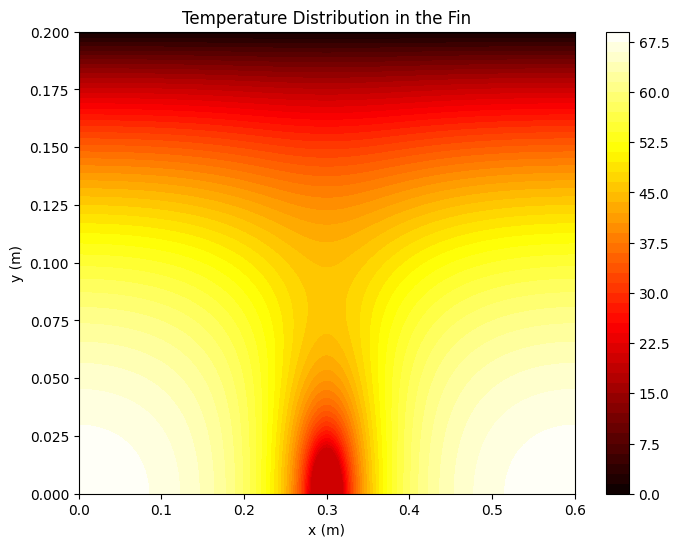

In [6]:
# Plot the temperature distribution
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, T_grid, 50, cmap='hot')
plt.colorbar(cp)
plt.title('Temperature Distribution in the Fin')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()